<a href="https://colab.research.google.com/github/kadmanikanta/stock_portfolio_optimization/blob/main/optimizaatioon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import yfinance as yf
from datetime import date, timedelta

# define the time period for the data
end_date = date.today().strftime("%Y-%m-%d")
start_date = (date.today() - timedelta(days=365)).strftime("%Y-%m-%d")

# list of stock tickers to download
tickers = ['RELIANCE.NS', 'TCS.NS', 'INFY.NS', 'HDFCBANK.NS']

data = yf.download(tickers, start=start_date, end=end_date, progress=False)

# reset index to bring Date into the columns for the melt function
data = data.reset_index()

# melt the DataFrame to make it long format where each row is a unique combination of Date, Ticker, and attributes
data_melted = data.melt(id_vars=['Date'], var_name=['Attribute', 'Ticker'])

# pivot the melted DataFrame to have the attributes (Open, High, Low, etc.) as columns
data_pivoted = data_melted.pivot_table(index=['Date', 'Ticker'], columns='Attribute', values='value', aggfunc='first')

# reset index to turn multi-index into columns
stock_data = data_pivoted.reset_index()

print(stock_data.head())

Attribute                      Date       Ticker    Adj Close        Close  \
0         2023-09-11 00:00:00+00:00  HDFCBANK.NS  1609.817261  1631.800049   
1         2023-09-11 00:00:00+00:00      INFY.NS  1437.161499  1476.449951   
2         2023-09-11 00:00:00+00:00  RELIANCE.NS  2466.229736  2474.600098   
3         2023-09-11 00:00:00+00:00       TCS.NS  3430.699951  3480.649902   
4         2023-09-12 00:00:00+00:00  HDFCBANK.NS  1614.848511  1636.900024   

Attribute         High          Low         Open      Volume  
0          1636.500000  1624.000000  1628.900024  15786511.0  
1          1478.050049  1464.500000  1469.599976   4182226.0  
2          2476.850098  2452.000000  2452.000000   6635537.0  
3          3485.699951  3445.000000  3462.000000   1783604.0  
4          1642.900024  1625.050049  1640.000000  19516670.0  


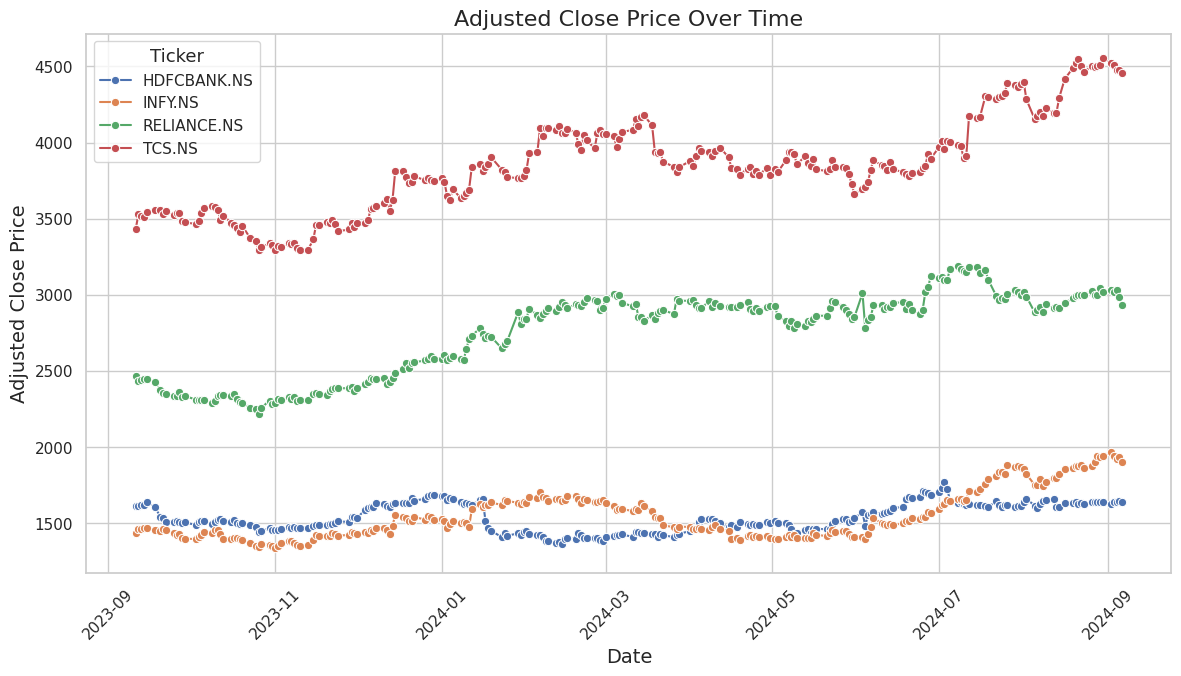

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

stock_data['Date'] = pd.to_datetime(stock_data['Date'])

stock_data.set_index('Date', inplace=True)
stock_data.reset_index(inplace=True)
plt.figure(figsize=(14, 7))
sns.set(style='whitegrid')

sns.lineplot(data=stock_data, x='Date', y='Adj Close', hue='Ticker', marker='o')

plt.title('Adjusted Close Price Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Adjusted Close Price', fontsize=14)
plt.legend(title='Ticker', title_fontsize='13', fontsize='11')
plt.grid(True)

plt.xticks(rotation=45)

plt.show()

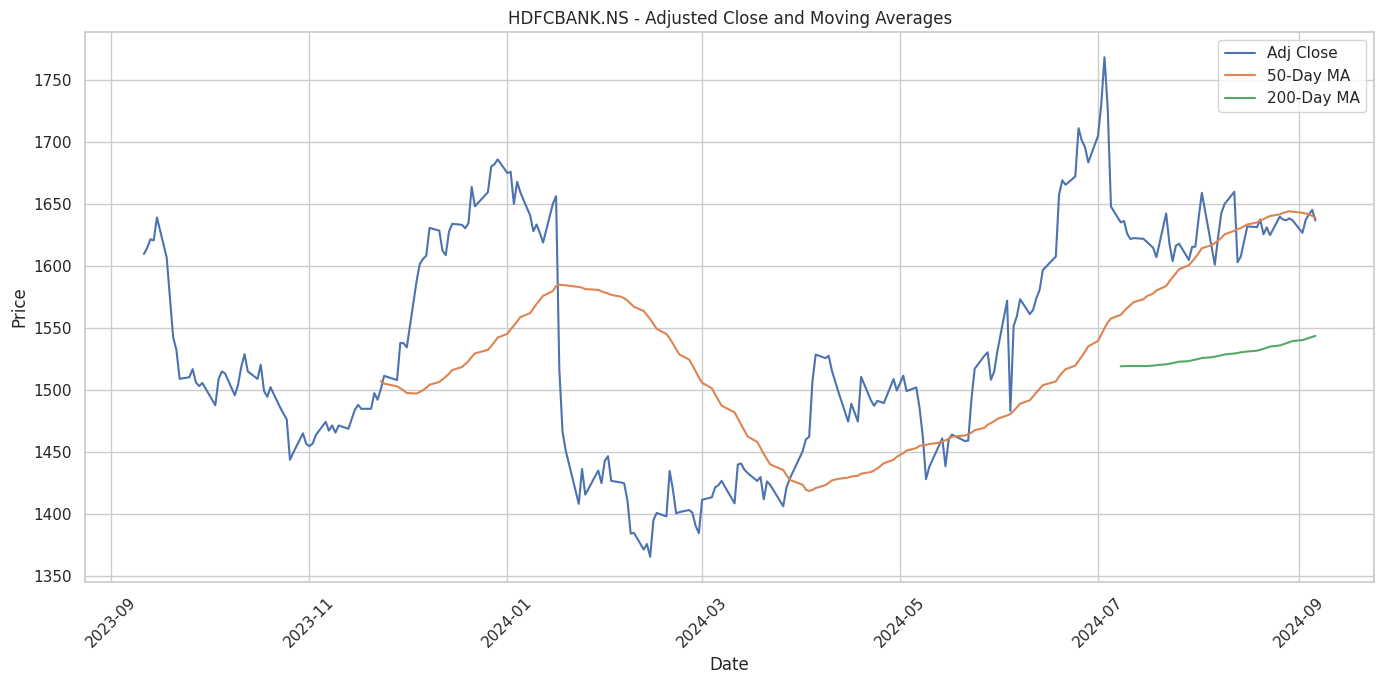

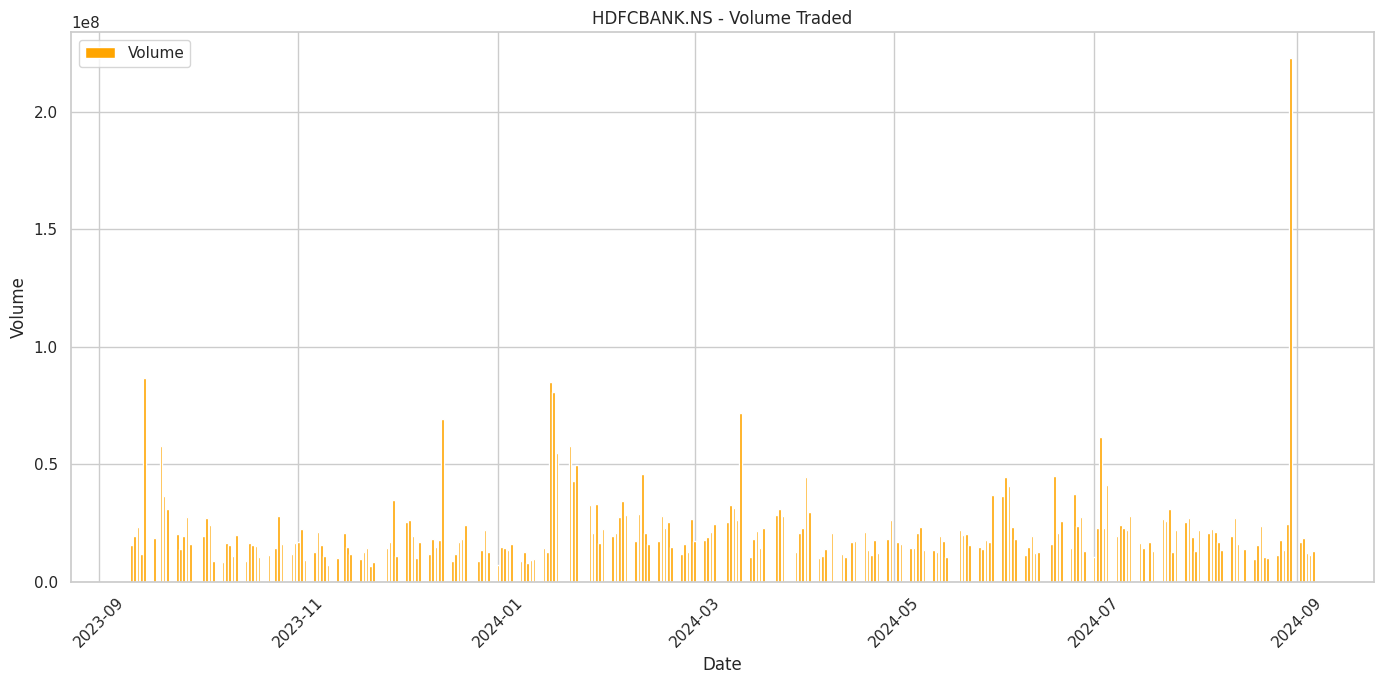

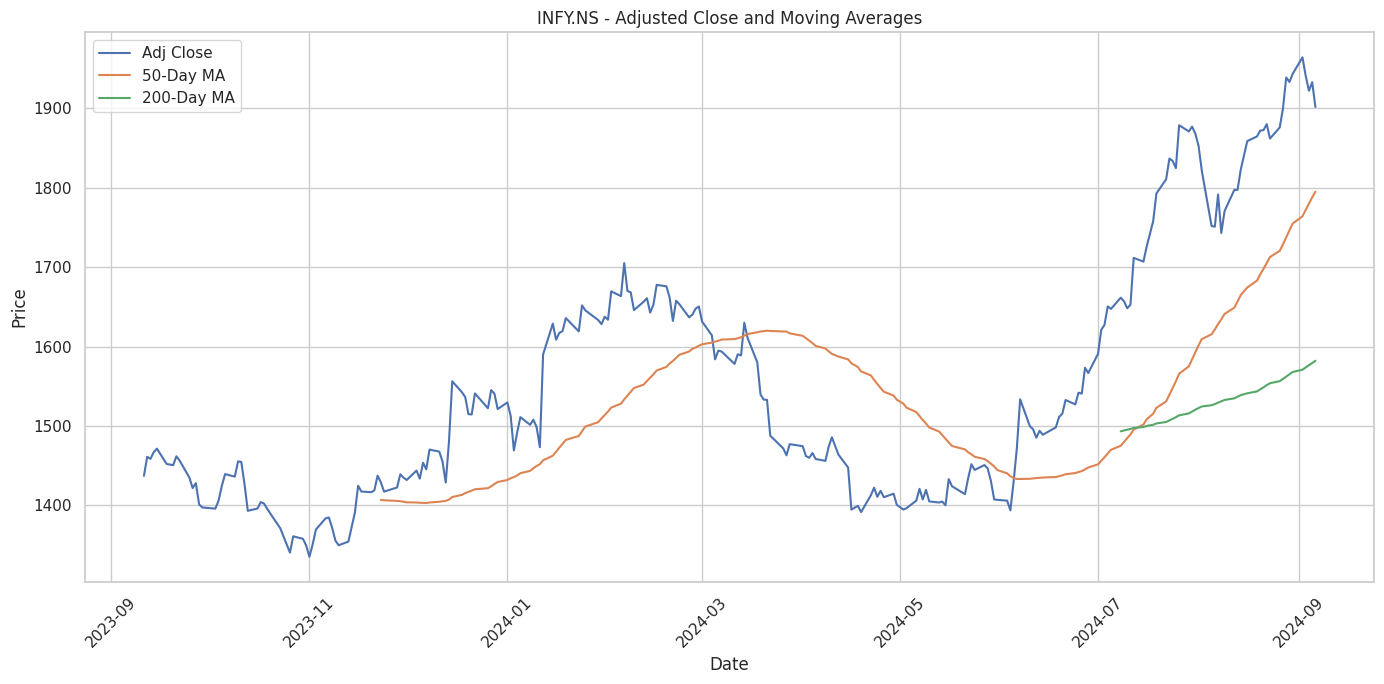

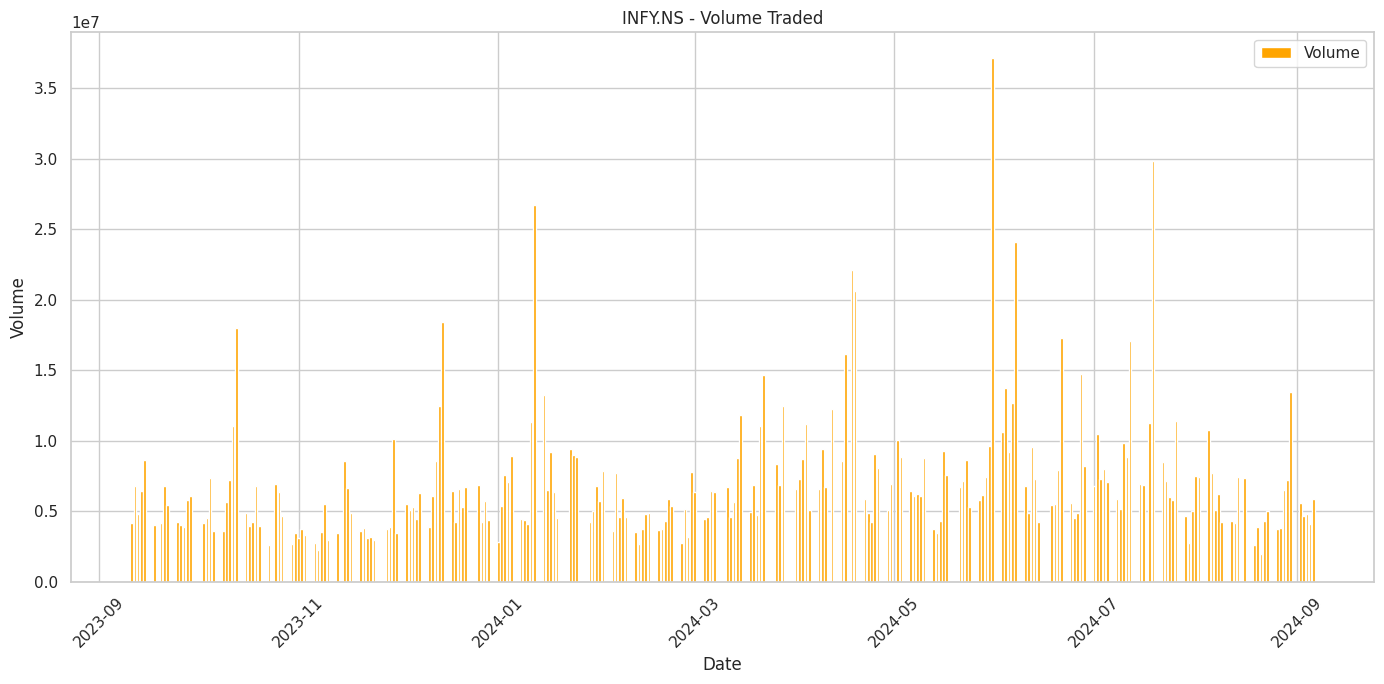

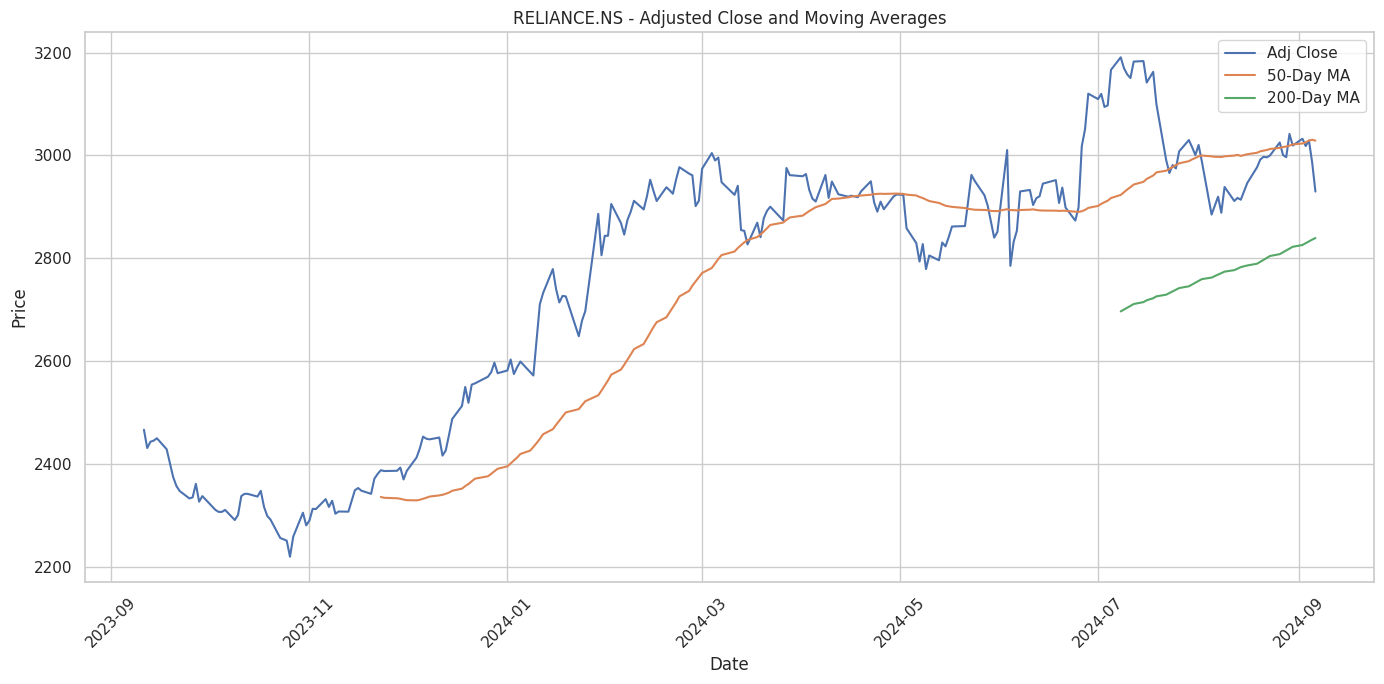

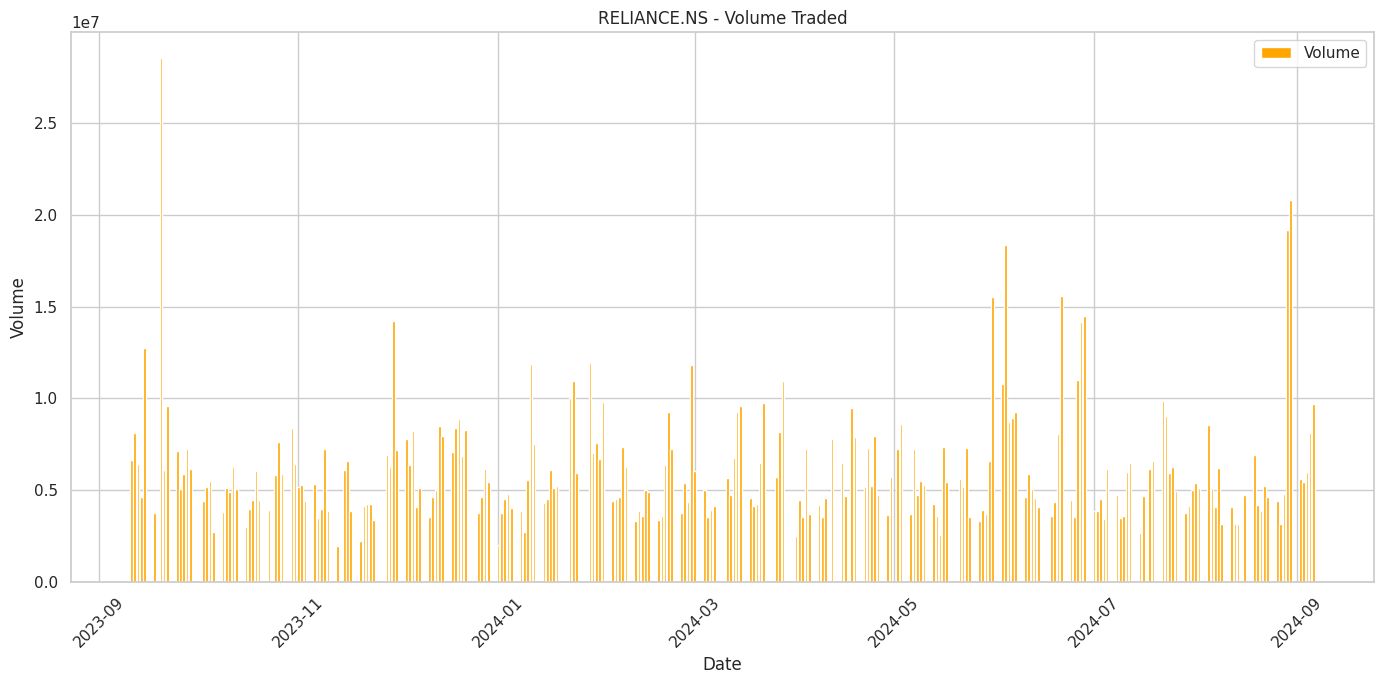

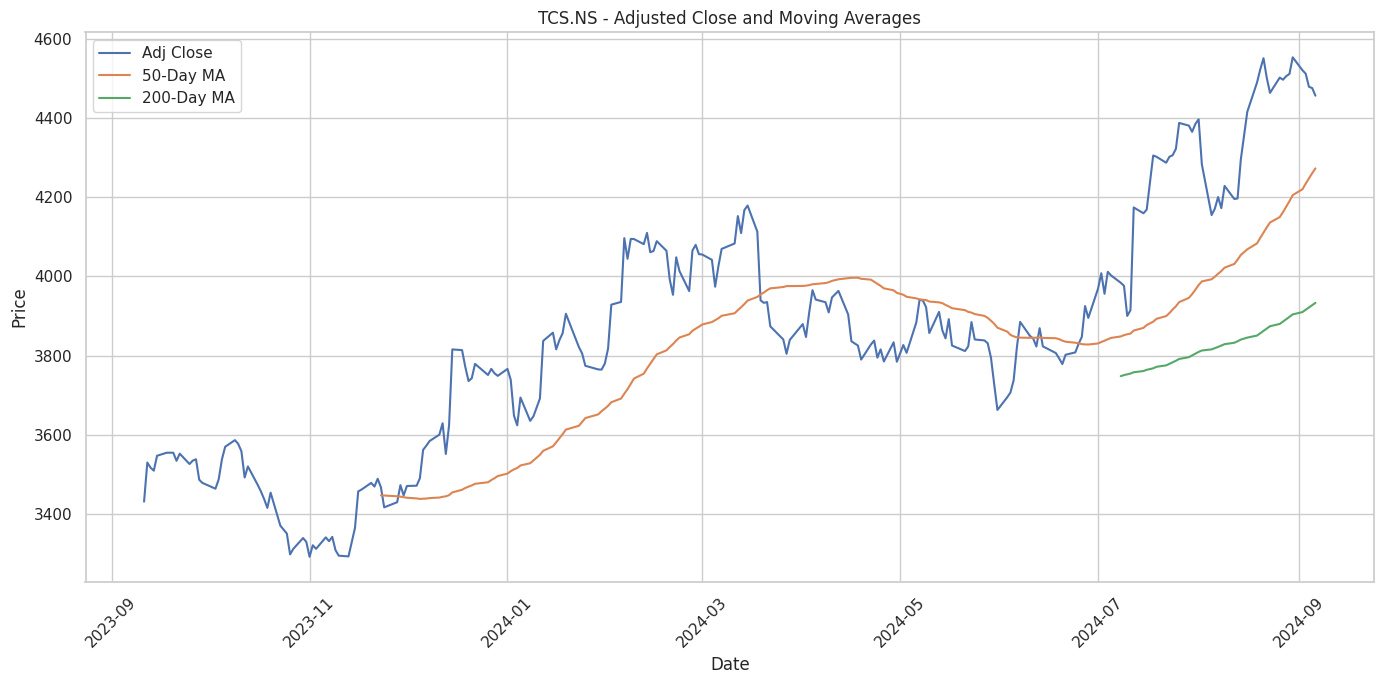

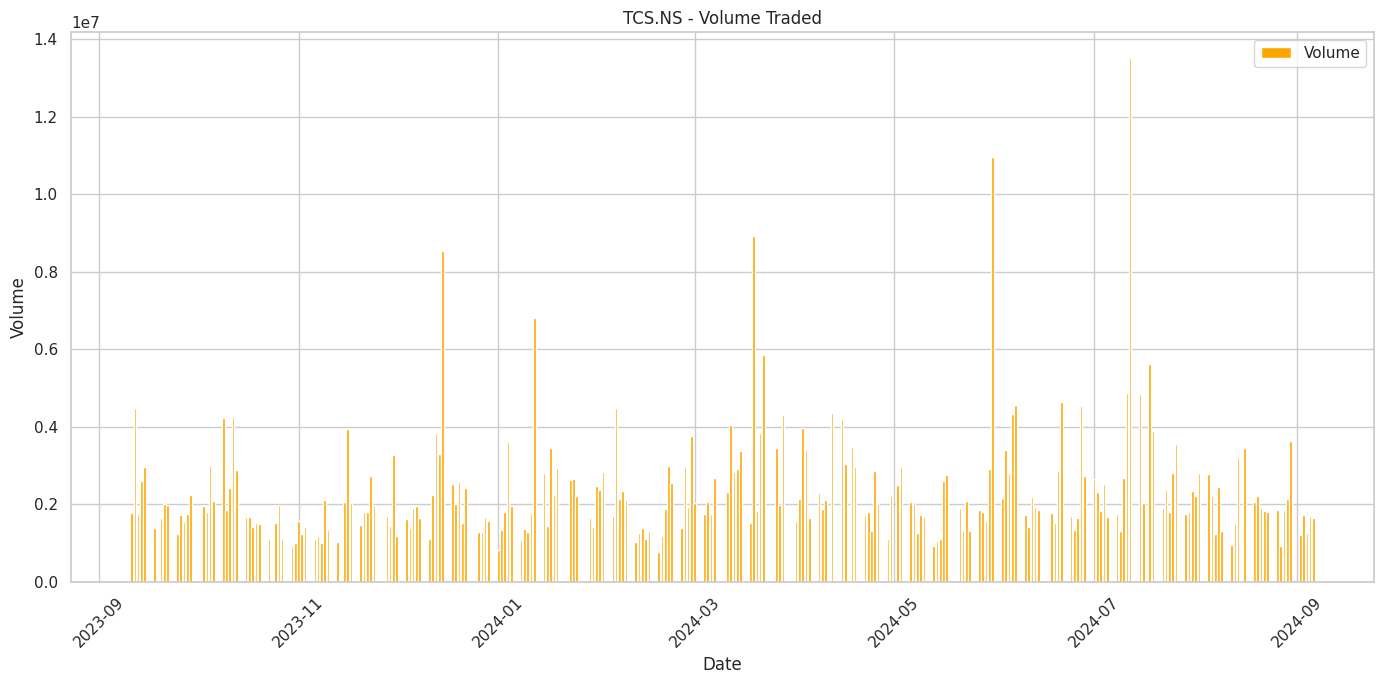

In [3]:
short_window = 50
long_window = 200

stock_data.set_index('Date', inplace=True)
unique_tickers = stock_data['Ticker'].unique()

for ticker in unique_tickers:
    ticker_data = stock_data[stock_data['Ticker'] == ticker].copy()
    ticker_data['50_MA'] = ticker_data['Adj Close'].rolling(window=short_window).mean()
    ticker_data['200_MA'] = ticker_data['Adj Close'].rolling(window=long_window).mean()

    plt.figure(figsize=(14, 7))
    plt.plot(ticker_data.index, ticker_data['Adj Close'], label='Adj Close')
    plt.plot(ticker_data.index, ticker_data['50_MA'], label='50-Day MA')
    plt.plot(ticker_data.index, ticker_data['200_MA'], label='200-Day MA')
    plt.title(f'{ticker} - Adjusted Close and Moving Averages')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14, 7))
    plt.bar(ticker_data.index, ticker_data['Volume'], label='Volume', color='orange')
    plt.title(f'{ticker} - Volume Traded')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

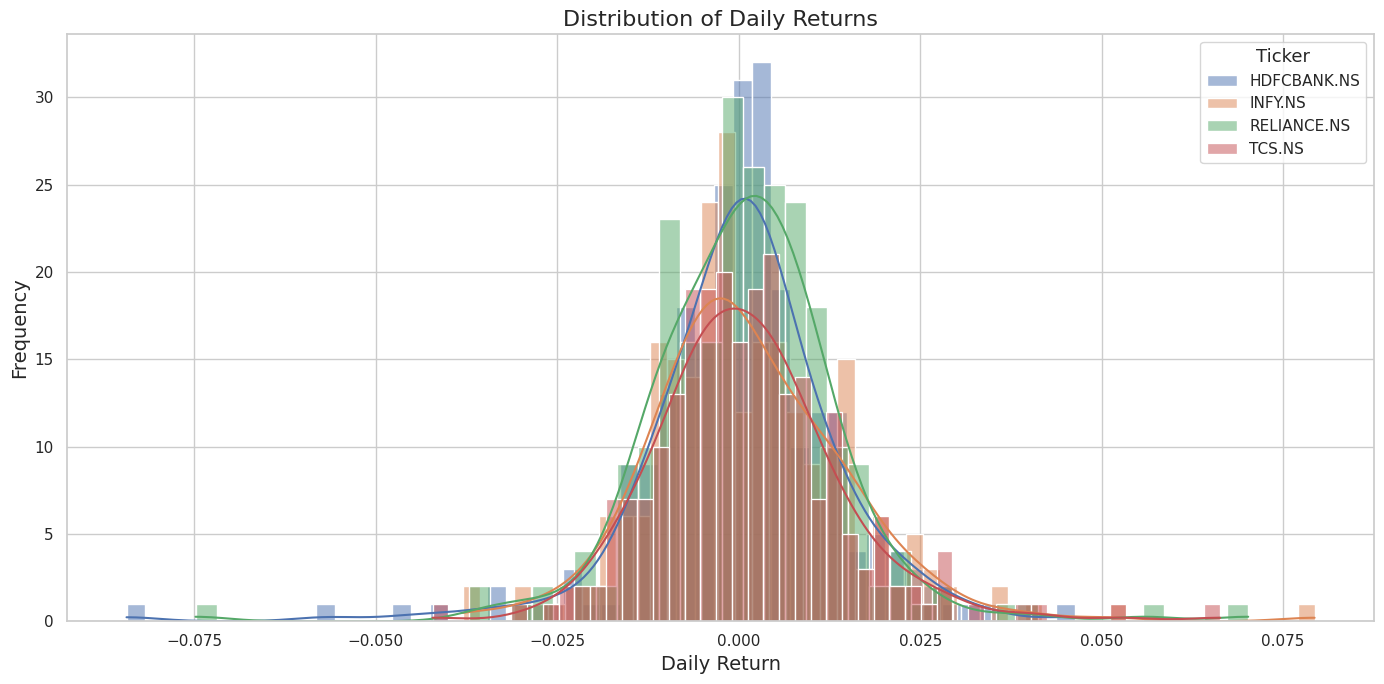

In [4]:
stock_data['Daily Return'] = stock_data.groupby('Ticker')['Adj Close'].pct_change()

plt.figure(figsize=(14, 7))
sns.set(style='whitegrid')

for ticker in unique_tickers:
    ticker_data = stock_data[stock_data['Ticker'] == ticker]
    sns.histplot(ticker_data['Daily Return'].dropna(), bins=50, kde=True, label=ticker, alpha=0.5)

plt.title('Distribution of Daily Returns', fontsize=16)
plt.xlabel('Daily Return', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(title='Ticker', title_fontsize='13', fontsize='11')
plt.grid(True)
plt.tight_layout()
plt.show()

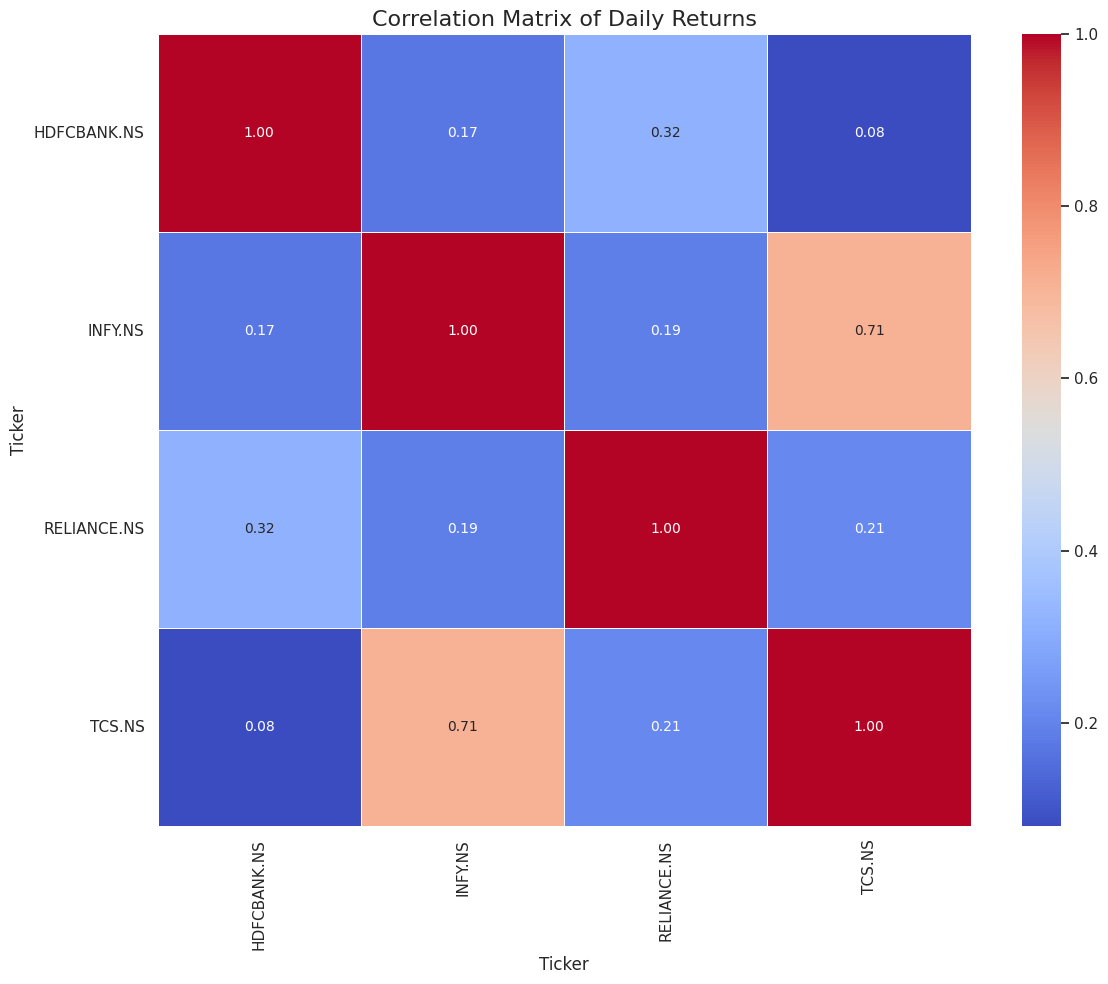

In [5]:
daily_returns = stock_data.pivot_table(index='Date', columns='Ticker', values='Daily Return')
correlation_matrix = daily_returns.corr()

plt.figure(figsize=(12, 10))
sns.set(style='whitegrid')

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5, fmt='.2f', annot_kws={"size": 10})
plt.title('Correlation Matrix of Daily Returns', fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [6]:
import numpy as np

expected_returns = daily_returns.mean() * 252  # annualize the returns
volatility = daily_returns.std() * np.sqrt(252)  # annualize the volatility

stock_stats = pd.DataFrame({
    'Expected Return': expected_returns,
    'Volatility': volatility
})

stock_stats

,Expected Return,Volatility
Ticker,,
HDFCBANK.NS,0.041195,0.216907
INFY.NS,0.317607,0.222838
RELIANCE.NS,0.203043,0.214643
TCS.NS,0.295025,0.207574


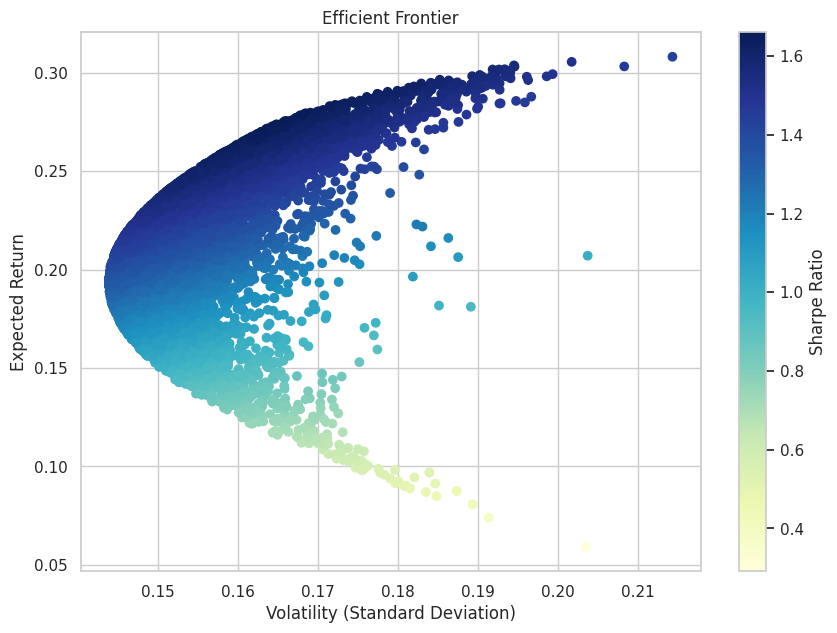

In [7]:
# function to calculate portfolio performance
def portfolio_performance(weights, returns, cov_matrix):
    portfolio_return = np.dot(weights, returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_volatility

# number of portfolios to simulate
num_portfolios = 10000

# arrays to store the results
results = np.zeros((3, num_portfolios))

# annualized covariance matrix
cov_matrix = daily_returns.cov() * 252

np.random.seed(42)

for i in range(num_portfolios):
    weights = np.random.random(len(unique_tickers))
    weights /= np.sum(weights)

    portfolio_return, portfolio_volatility = portfolio_performance(weights, expected_returns, cov_matrix)

    results[0,i] = portfolio_return
    results[1,i] = portfolio_volatility
    results[2,i] = portfolio_return / portfolio_volatility  # Sharpe Ratio

plt.figure(figsize=(10, 7))
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='YlGnBu', marker='o')
plt.title('Efficient Frontier')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')
plt.grid(True)
plt.show()

In [8]:
max_sharpe_idx = np.argmax(results[2])
max_sharpe_return = results[0, max_sharpe_idx]
max_sharpe_volatility = results[1, max_sharpe_idx]
max_sharpe_ratio = results[2, max_sharpe_idx]

max_sharpe_return, max_sharpe_volatility, max_sharpe_ratio

(0.2737538918221578, 0.1648505465713884, 1.6606186483197913)

In [9]:
max_sharpe_weights = np.zeros(len(unique_tickers))

for i in range(num_portfolios):
    weights = np.random.random(len(unique_tickers))
    weights /= np.sum(weights)

    portfolio_return, portfolio_volatility = portfolio_performance(weights, expected_returns, cov_matrix)

    if results[2, i] == max_sharpe_ratio:
        max_sharpe_weights = weights
        break

portfolio_weights_df = pd.DataFrame({
    'Ticker': unique_tickers,
    'Weight': max_sharpe_weights
})

portfolio_weights_df

,Ticker,Weight
0,HDFCBANK.NS,0.281504
1,INFY.NS,0.245652
2,RELIANCE.NS,0.268975
3,TCS.NS,0.203869
